In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors
import seaborn as sns

In [2]:
# sf stands for shape file
sf = gpd.read_file("../data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../data/taxi_zones/taxi+_zone_lookup.csv")

In [3]:
# Taken from Tutorial 2
gdf = gpd.GeoDataFrame(pd.merge(zones, sf, on='LocationID', how='inner'))

geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

gdf.head()

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,Newark Airport,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,Queens,Jamaica Bay,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((1026308.77 256767.698, 1026495.593 2..."
3,4,Manhattan,Alphabet City,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,Staten Island,Arden Heights,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((935843.31 144283.336, 936046.565 144..."


In [4]:
df = pd.read_parquet("../data/tlc_data/curated/2023_tlc_sample.parquet/")

In [5]:
# Compute pickup and dropoff amount of each zone
pu_zone = df.groupby(['pulocationid'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, gdf, left_on='pulocationid', right_on='LocationID')).drop('LocationID', axis=1)
pu_zone = pu_zone.to_crs(epsg=3857)

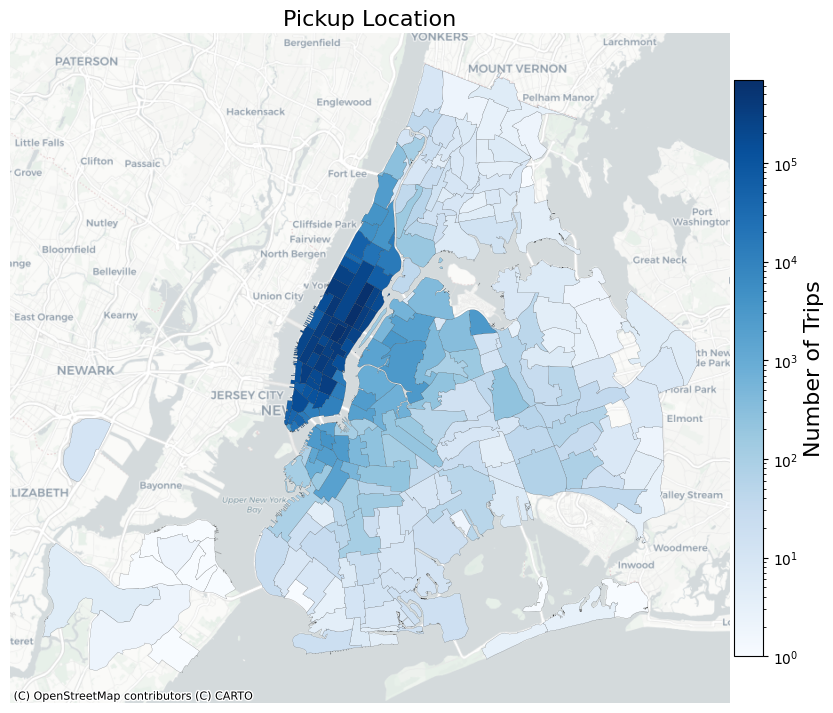

In [6]:
# plot geospatial visualization for pickup amount from each zone
fig, ax = plt.subplots(figsize=(12, 10))

# Adjust figure settings
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Create a normalized colorbar based on the pickup zone data using a logarithmic scale
vmin, vmax = pu_zone['size'].min(), pu_zone['size'].max()
norm = colors.LogNorm(vmin=vmin, vmax=vmax)

ax = pu_zone.plot(column='size', linewidth=0.09, edgecolor='k', 
                  norm=norm, cmap='Blues', legend=False, ax=ax) 

# Add a basemap
ctx.add_basemap(ax, crs=pu_zone.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set the title
ax.set_title('Pickup Location', fontsize=16)

# Remove axis
ax.set_axis_off()

# Draw the color bar
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Number of Trips', fontsize=16)

# Show the plot
plt.show()

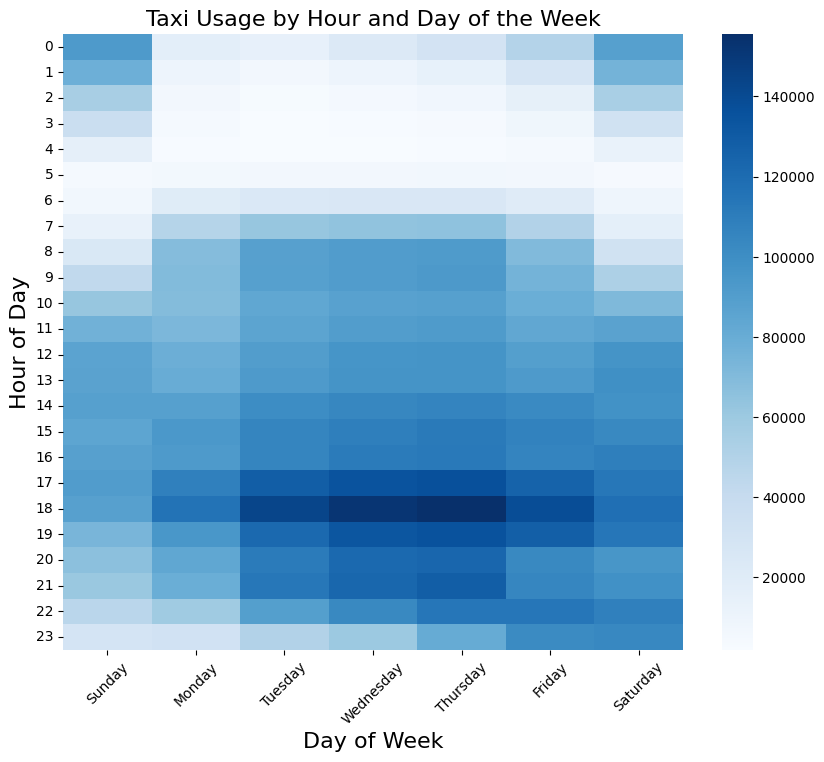

In [7]:
# Define the mapping from numbers to day names (if you prefer to keep numbers, you can skip this step)
day_order = [1, 2, 3, 4, 5, 6, 7]
day_names = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Create a crosstab of day_of_week and hour
pu_count = pd.crosstab(df['day_of_week'], df['hour'])

# Reindex to ensure the days are in the correct order
pu_count = pu_count.reindex(day_order, axis=0)
pu_count.index = day_names

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pu_count.transpose(), cmap="Blues", cbar=True)

# Customization of the plot
plt.title('Taxi Usage by Hour and Day of the Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('Hour of Day', fontsize=16)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

In [9]:
# Define the order and labels for days of the week
day_order = [1, 2, 3, 4, 5, 6, 7]
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

# Ensure 'day_of_week' and 'hour' columns are of integer type
df['day_of_week'] = df['day_of_week'].astype(int)
df['hour'] = df['hour'].astype(int)

# Group by 'day_of_week' and 'hour' to calculate the mean profitability
profitability = df.groupby(['day_of_week', 'hour'])['profitability'].mean().reset_index()

In [10]:
# Create a pivot table with 'day_of_week' as rows and 'hour' as columns
profit_pivot = profitability.pivot(index='day_of_week', columns='hour', values='profitability')

# Reindex the rows to ensure correct day order
profit_pivot = profit_pivot.reindex(day_order)

# Rename the index to use day labels instead of numbers
profit_pivot.index = day_labels

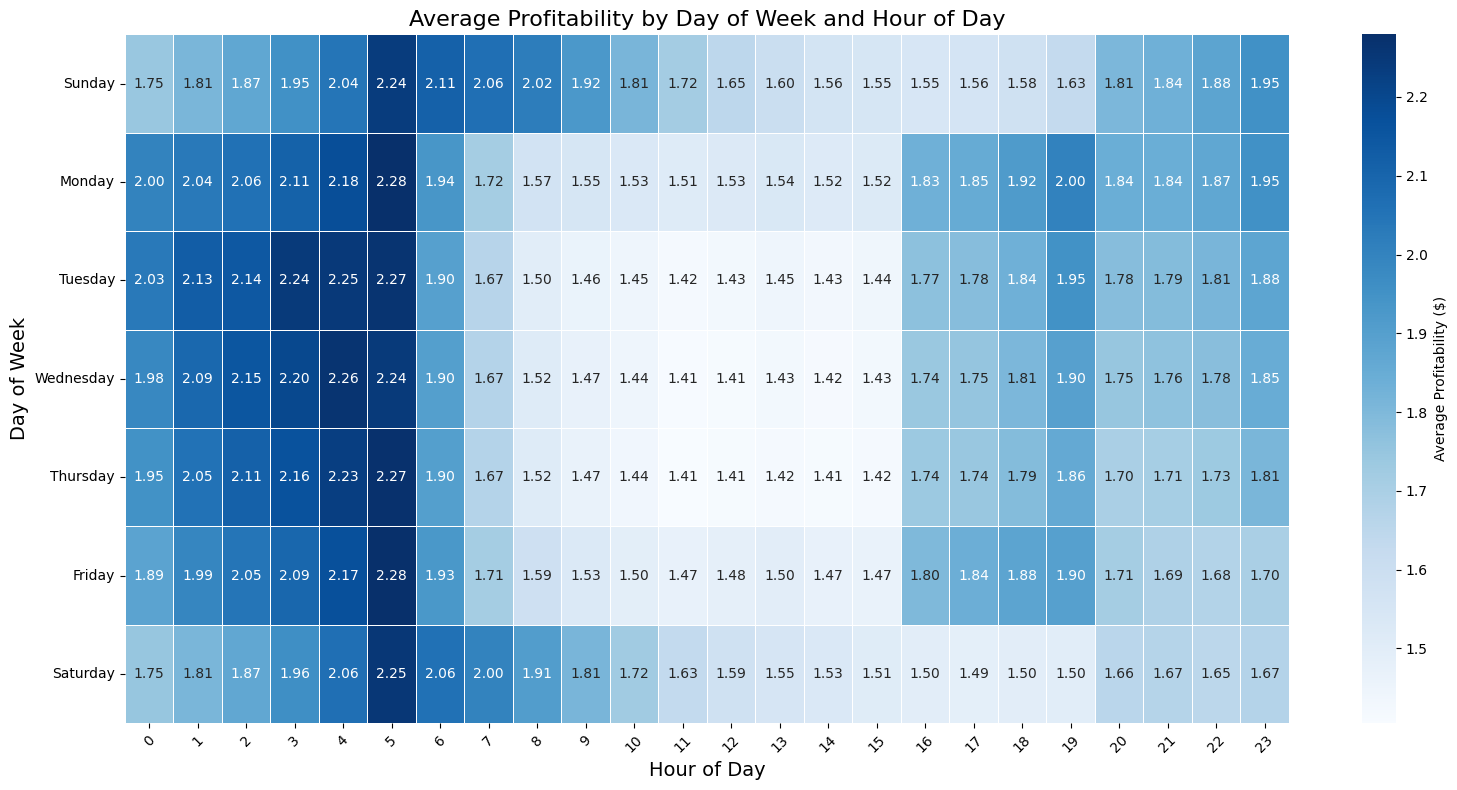

In [11]:
# Set the figure size
plt.figure(figsize=(16, 8))

# Create the heatmap
sns.heatmap(profit_pivot, annot=True, fmt=".2f", cmap="Blues", linewidths=.5, cbar_kws={'label': 'Average Profitability ($)'})

# Set labels and title
plt.title('Average Profitability by Day of Week and Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Day of Week', fontsize=14)

# Adjust tick labels for better readability
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Display the plot
plt.tight_layout()
plt.show()

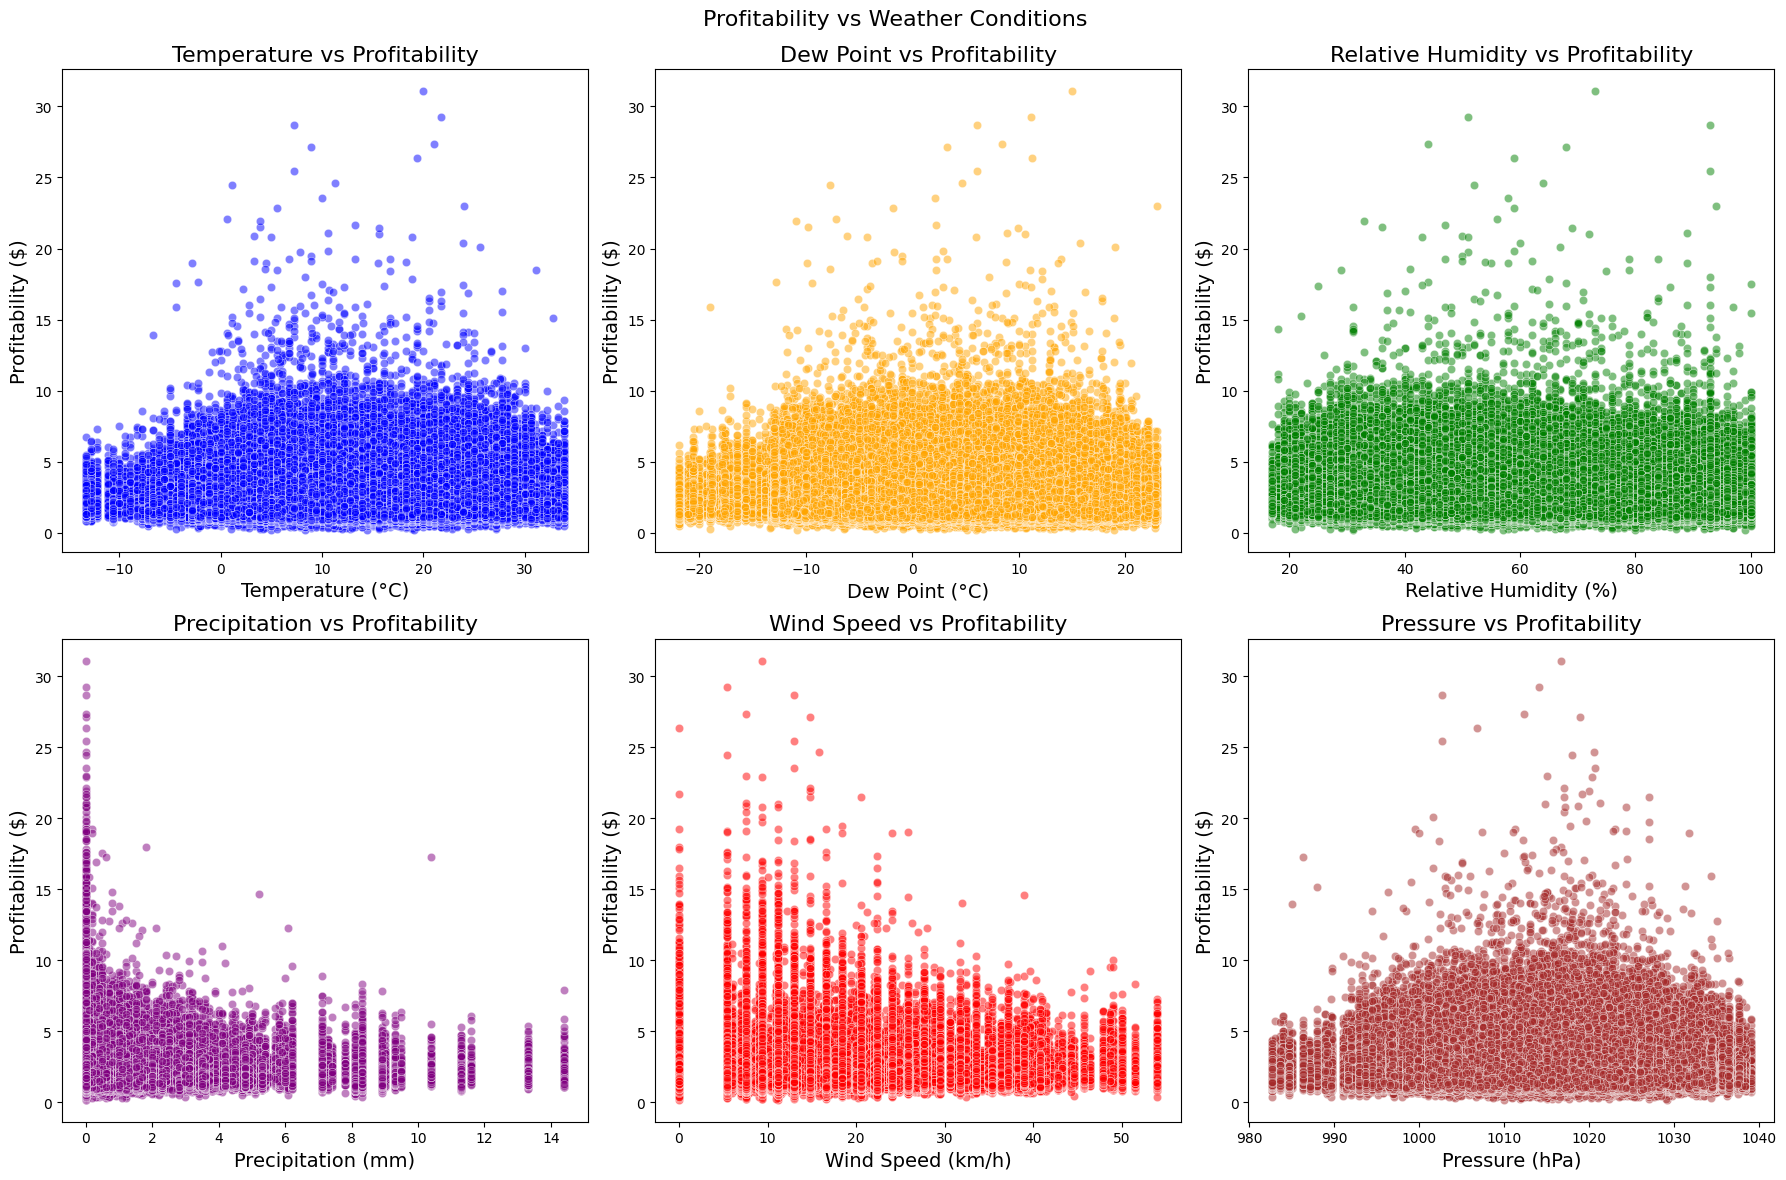

In [12]:
# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plot profitability vs temperature
sns.scatterplot(x='temp', y='profitability', data=df, ax=axs[0, 0], color='blue', alpha=0.5)
axs[0, 0].set_title('Temperature vs Profitability', fontsize=16)
axs[0, 0].set_xlabel('Temperature (°C)', fontsize=14)
axs[0, 0].set_ylabel('Profitability ($)', fontsize=14)

# Plot profitability vs dew point
sns.scatterplot(x='dwpt', y='profitability', data=df, ax=axs[0, 1], color='orange', alpha=0.5)
axs[0, 1].set_title('Dew Point vs Profitability', fontsize=16)
axs[0, 1].set_xlabel('Dew Point (°C)', fontsize=14)
axs[0, 1].set_ylabel('Profitability ($)', fontsize=14)

# Plot profitability vs relative humidity
sns.scatterplot(x='rhum', y='profitability', data=df, ax=axs[0, 2], color='green', alpha=0.5)
axs[0, 2].set_title('Relative Humidity vs Profitability', fontsize=16)
axs[0, 2].set_xlabel('Relative Humidity (%)', fontsize=14)
axs[0, 2].set_ylabel('Profitability ($)', fontsize=14)

# Plot profitability vs precipitation
sns.scatterplot(x='prcp', y='profitability', data=df, ax=axs[1, 0], color='purple', alpha=0.5)
axs[1, 0].set_title('Precipitation vs Profitability', fontsize=16)
axs[1, 0].set_xlabel('Precipitation (mm)', fontsize=14)
axs[1, 0].set_ylabel('Profitability ($)', fontsize=14)

# Plot profitability vs wind speed
sns.scatterplot(x='wspd', y='profitability', data=df, ax=axs[1, 1], color='red', alpha=0.5)
axs[1, 1].set_title('Wind Speed vs Profitability', fontsize=16)
axs[1, 1].set_xlabel('Wind Speed (km/h)', fontsize=14)
axs[1, 1].set_ylabel('Profitability ($)', fontsize=14)

# Plot profitability vs pressure
sns.scatterplot(x='pres', y='profitability', data=df, ax=axs[1, 2], color='brown', alpha=0.5)
axs[1, 2].set_title('Pressure vs Profitability', fontsize=16)
axs[1, 2].set_xlabel('Pressure (hPa)', fontsize=14)
axs[1, 2].set_ylabel('Profitability ($)', fontsize=14)

# Adjust layout
plt.suptitle('Profitability vs Weather Conditions', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.93)

plt.show()

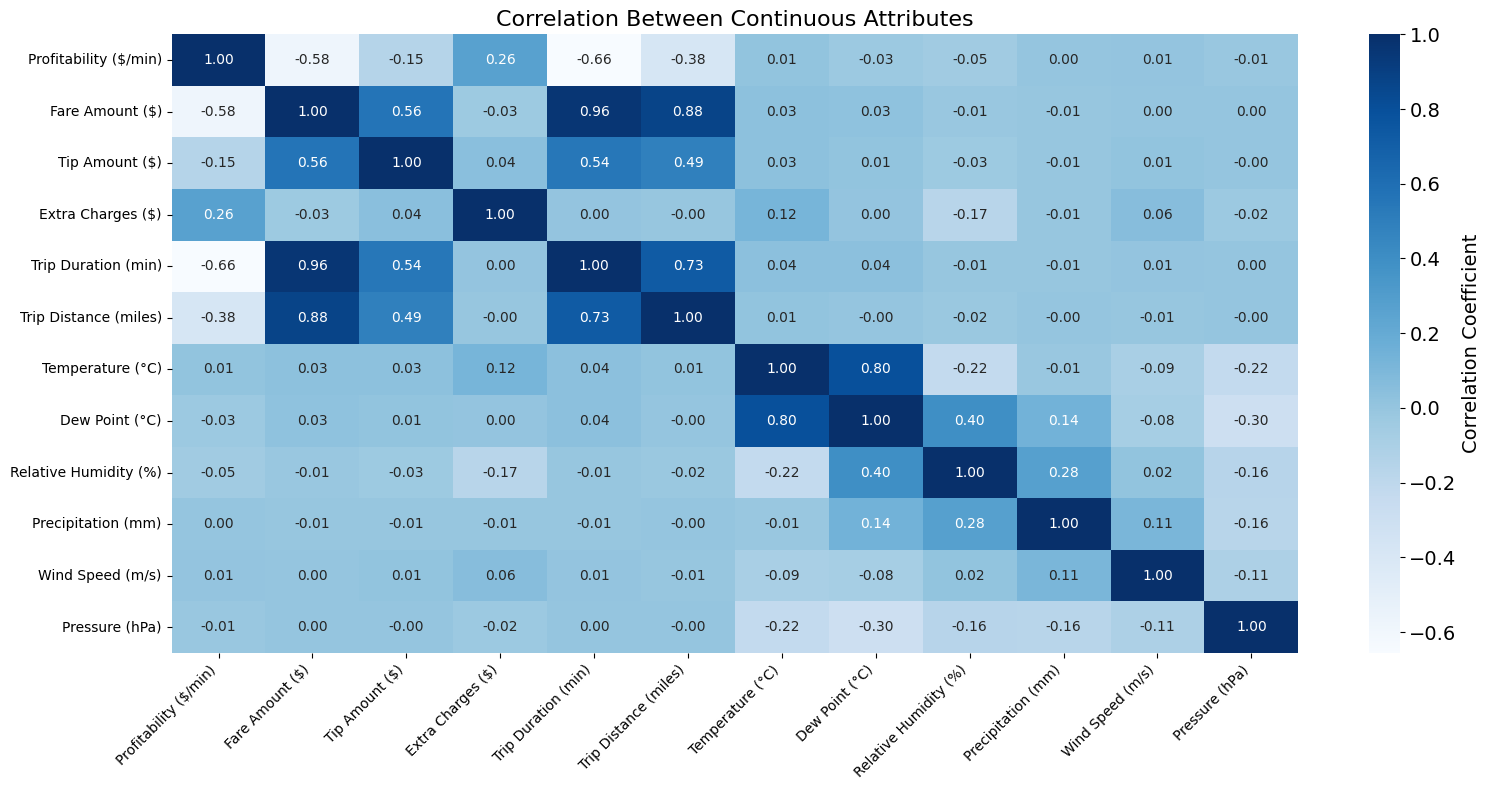

In [13]:
# Define columns and labels
col = [
    'profitability', 'fare_amount', 'tip_amount', 'extra', 
    'trip_duration', 'trip_distance','temp', 'dwpt', 'rhum', 
    'prcp', 'wspd', 'pres'
]

labels = [
    "Profitability ($/min)",
    "Fare Amount ($)",
    "Tip Amount ($)",
    "Extra Charges ($)",
    "Trip Duration (min)",
    "Trip Distance (miles)",
    "Temperature (°C)",
    "Dew Point (°C)",
    "Relative Humidity (%)",
    "Precipitation (mm)",
    "Wind Speed (m/s)",
    "Pressure (hPa)"
]

# Compute correlation matrix
corr_matrix = df[col].corr()

# Plot correlation matrix
fig, ax = plt.subplots(figsize=(16, 8))
heatmap = sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="Blues", 
                      cbar_kws={'label': 'Correlation Coefficient'}) 

# Adjust color bar font size
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation Coefficient', fontsize=14)

ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels, rotation=0)
ax.set_title("Correlation Between Continuous Attributes", fontsize=16)
plt.tight_layout()
plt.show()

In [14]:
# Calculate mean profitability per pulocationid
profitability_zone = df.groupby(['pulocationid'], as_index=False)['profitability'].mean()

# Merge with geographical data
profitability_zone = gpd.GeoDataFrame(pd.merge(profitability_zone, gdf, left_on='pulocationid', right_on='LocationID').drop('LocationID', axis=1))
profitability_zone = profitability_zone.to_crs(epsg=3857)

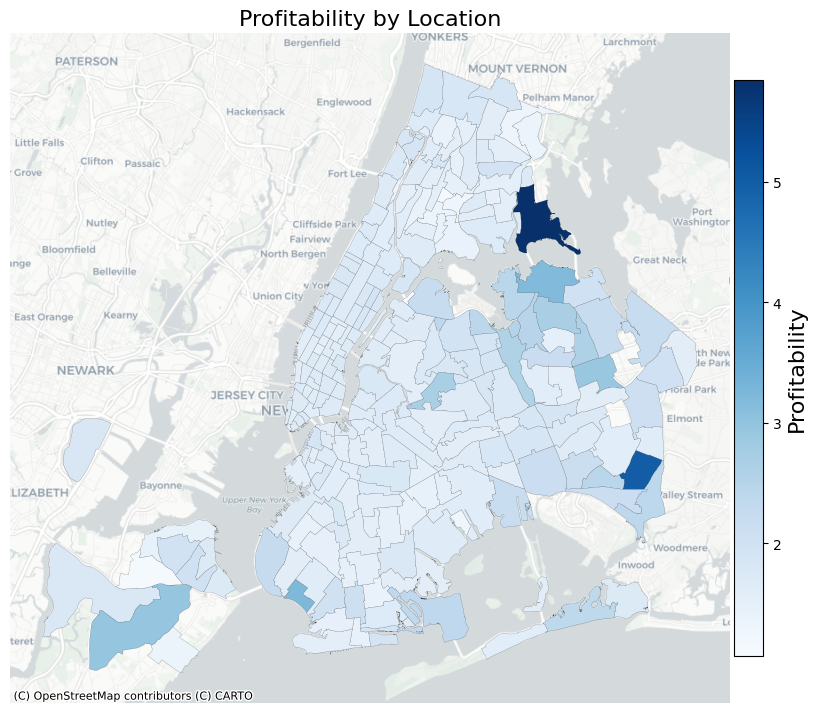

In [15]:
# Plot geospatial visualization for profitability by location
fig, ax = plt.subplots(figsize=(12, 10))

# Adjust figure settings
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8)

# Plot the profitability data on the map with normal color scaling
ax = profitability_zone.plot(column='profitability', linewidth=0.09, edgecolor='k', 
                              cmap='Blues', legend=False, ax=ax) 

# Add a basemap
ctx.add_basemap(ax, crs=profitability_zone.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Set the title
ax.set_title('Profitability by Location', fontsize=16)

# Remove axis
ax.set_axis_off()

# Draw the color bar
patch_col = ax.collections[0]
cb = fig.colorbar(patch_col, ax=ax, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Profitability', fontsize=16)

# Show the plot
plt.show()